In [1]:
import seaborn as sns

sns.set_theme(
    rc={"axes.spines.top": False, "axes.spines.right": False, "figure.autolayout": True},
    style="ticks",
)

# Computing likelihood value

Given a successful installation of `MFLike` data (see [tutorial](tutorial_loading.ipynb)), we can now retrieve likelihood or $\chi^2$ value given the set of parameter values. First, let's load the `MFLike` instance

In [2]:
%run tutorial_loading.ipynb

     Numpy : 1.24.3
Matplotlib : 3.8.0
      CAMB : 1.5.7
    Cobaya : 3.5.1
[install] Installing external packages at 'C:\Users\micro\AppData\Local\Temp\LAT_packages'

likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at C:\Users\micro\AppData\Local\Temp\LAT_packages
[camb] `camb` module loaded successfully from C:\Work\Dist\git\camb\camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


We can retrieve informations related to likelihood(s) as follow



In [3]:
loglikes, derived = model.loglikes()
print(f"log-likelihood value = {loglikes}")

log-likelihood value = [-3586.61673018]


We can directly catch the value returned by `logp` function from `MFLike` likelihood

In [4]:
logp = mflike.logp(**fg_params, **nuisance_params)
print(f"log-likelihood value = {logp}")
print(f"Χ² value = {-2 * (logp - mflike.logp_const)}")

log-likelihood value = -3586.6167301770643
Χ² value = 3096.869255634852


Finally, we can also use the `evaluate` sampler that evaluates the log-likelihood at a given reference point

In [5]:
from cobaya.run import run

info["sampler"] = {"evaluate": None}
updated_info, products = run(info)

[camb] `camb` module loaded successfully from C:\Work\Dist\git\camb\camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!
[evaluate] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -3586.62
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -3586.62
[evaluate]    chi2_mflike.MFLike = 7173.23
[evaluate] Derived params:


## Using the `MFLike` likelihood without `cobaya`

The `MFLike` likelihood can also be used independently of `cobaya`. The principle is the same as in
this `cobaya`'s [example](https://github.com/CobayaSampler/planck_lensing_external). First we need
to instantiate an `MFLike` object



In [11]:
from mflike import TTTEEE, BandpowerForeground

ext_mflike = TTTEEE(mflike_input_file, packages_path=packages_path)
foreground_model = BandpowerForeground(ext_mflike.get_fg_requirements())

[mflike] Number of bins used: 3087
[mflike] Initialized!


The $C_\ell$ dictionary can be retrieved from an independant program or an independant computation. Here we will use `CAMB` to compute the $C_\ell$ from a cosmological model set by the `cosmo_params`

In [7]:
camb_cosmo = cosmo_params | minimal_settings
camb_cosmo.update(lmax=ext_mflike.lmax_theory + 1)

pars = camb.set_params(**camb_cosmo)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
dls_camb = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}

We also get the $D_\ell$ from `cobaya` (see [tutorial](tutorial_foregrounds.ipynb))

In [8]:
dls_cobaya = model.theory["camb"].get_Cl(ell_factor=True)

Let's plot $D_\ell$ and let's compare them to the ones from `cobaya`

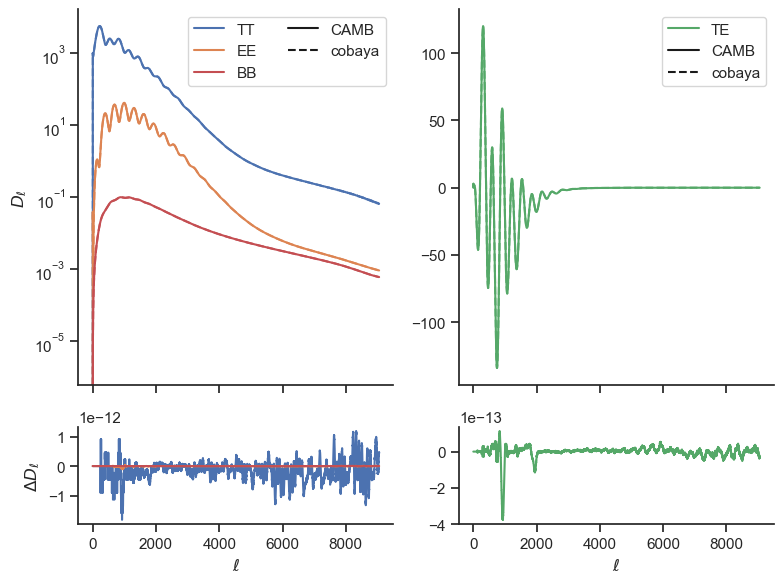

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(4, 2)
axes = {
    "tt": [fig.add_subplot(gs[:3, 0], xticklabels=[]), fig.add_subplot(gs[-1, 0])],
    "te": [fig.add_subplot(gs[:3, 1], xticklabels=[]), fig.add_subplot(gs[-1, 1])],
}


ell = dls_cobaya["ell"]
for i, mode in enumerate(dls_camb):
    plot = axes["te"][0].plot if mode == "te" else axes["tt"][0].semilogy
    plot(ell, dls_camb[mode], f"-C{i}", label=mode.upper())
    plot(ell, dls_cobaya[mode], f"--C{i}")
    ax = axes["te"][1] if mode == "te" else axes["tt"][1]
    ax.plot(ell, dls_camb[mode] - dls_cobaya[mode], f"-C{i}")

axes["tt"][0].set_ylabel(r"$D_\ell$")
axes["tt"][1].set_ylabel(r"$\Delta D_\ell$")
for mode in axes:
    axes[mode][1].set_xlabel(r"$\ell$")
    axes[mode][0].plot([], [], "-k", label="CAMB")
    axes[mode][0].plot([], [], "--k", label="cobaya")
    axes[mode][0].legend(ncol=1 if mode == "te" else 2)

To compute the log-likelihood value, we can use the `loglike` function which takes as parameters an theoretical $C_\ell$ dictionary and the nuisance parameter values. We can inject these $D_\ell$ into the `loglike` function to get the corresponding log-likelihood value

In [12]:
fg_dict = foreground_model.get_foreground_model_totals(**fg_params)
loglike = ext_mflike.loglike(dls_camb, fg_dict, **nuisance_params)
print(f"log-likelihood value = {loglike}")
print(f"Χ² value = {-2 * (loglike - ext_mflike.logp_const)}")

log-likelihood value = -3586.6167301770856
Χ² value = 3096.8692556348947


This way, `MFLike` likelihood is almost agnostic with respect to the sampler and can be used by others programs than `cobaya` as far as these programs provide $D_\ell$ spectra.